# Detecting signs of depression in Social Media

## About Data Set and depression

This project is based on data set created by: 
S Kayalvizhi and D Thenmozhi in 2022. Paper: "Data set creation and empirical analysis for detecting signs of depression from social media postings."
Data set was collected from Reddit archives of subreddits groups like: Mental Health, depression, loneliness, stress, anxiety. Data were pre-processed by removing the non-ASCII characters and emoticons to get a clean data set.  The collected postings data were annotated by two domain experts into three labels: “Not depressed, Moderate and Severe".

“Not Depressed" was annotade when data reflect one of the following mannerism:
- If the statements have only one or two lines about irrelevant topics. 
- If the statements reflect momentary feelings of present situation.
- If the statements are about asking questions about any or medication 
- If the statement is about ask/seek help for friend’s difficulties.

“Moderately depressed" was annotade when data falls under these conditions:
- If the statements reflect change in feelings (feeling low for some time and feeling better for some time). 
- If the statement shows that they aren’t feeling completely immersed in any situations
- If the statements show that they have hope for life.

“Severely depressed" was annotade when data have one of the following scenarios:
- If the statements express more than one disorder conditions. 
- If the statements explain about history of suicide attempts.

Because deppression can be diagnosed only by clinician expert using questionaries, clinical interwiev, patient observation and other technics, this annotation as depressed and moderately depressed cannot be treated as diagnosis. It is just assumption that user has signs of depression based on his/her declaration. 

**So what added value could be for such project?**
In my opinion value could be sygnificant:
Machine learning model could very fast detect sighns which looks like depression and could target such user with some information: for example sending them information about local clinicians, sending information about free help, invite to some neerest places for diagnosis, propose conversation with dedicated chatbot or specialist. 
Depression is higly corellated with suicidality and it could be far-fetched assumption but it can save someones live .

Let's start with importing all needed libraries

In [192]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.tokenize.casual import casual_tokenize
from nltk.stem import PorterStemmer
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# 1. Data preparation

Data set was stored in 3 files: train, dev and test. Test data did not have labels (because it was competition data to see competitors scores) so train and dev was concatenated to have one data set.
Let's see the data.

In [126]:
df1= pd.read_csv('train.tsv', sep='\t')
df2 = pd.read_csv('dev.tsv', sep='\t') 

In [127]:
df1.head()

,PID,Text_data,Label
0,train_pid_1,Waiting for my mind to have a breakdown once t...,moderate
1,train_pid_2,My new years resolution : I'm gonna get my ass...,moderate
2,train_pid_3,New year : Somone else Feeling like 2020 will ...,moderate
3,train_pid_4,"My story I guess : Hi, Im from Germany and my ...",moderate
4,train_pid_5,Sat in the dark and cried myself going into th...,moderate


In [128]:
df2.head()

,PID,Text data,Label
0,dev_pid_1,"I enjoyed today, and I still am! Tomorrows dep...",moderate
1,dev_pid_2,I sorta tried to kill myself : I had a total b...,moderate
2,dev_pid_3,Best suicide method? : I like it quick and eas...,moderate
3,dev_pid_4,a story : I remember the time I'd get on my 3D...,moderate
4,dev_pid_5,The world only cares about beautiful people : ...,moderate


We have different labels name and one column (PID) is not necessary.

In [129]:
df2.rename({'Text data': 'Text_data'}, inplace=True, axis='columns')
df = pd.concat([df1, df2], ignore_index=True)
df.drop(["PID"], axis=1, inplace=True)
df.head()

,Text_data,Label
0,Waiting for my mind to have a breakdown once t...,moderate
1,My new years resolution : I'm gonna get my ass...,moderate
2,New year : Somone else Feeling like 2020 will ...,moderate
3,"My story I guess : Hi, Im from Germany and my ...",moderate
4,Sat in the dark and cried myself going into th...,moderate


In [130]:
df.shape

(13387, 2)

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13387 entries, 0 to 13386
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text_data  13387 non-null  object
 1   Label      13387 non-null  object
dtypes: object(2)
memory usage: 209.3+ KB


We can see we have 13387 rows and 2 columns. All data are in string format (object dtype). 
Let's see if we have duplicates.

In [135]:
df.drop_duplicates(inplace=True, ignore_index=True)

In [136]:
df.shape

(7115, 2)

There are a lot of duplcates, all were deleted.
Let's see how target is distributed in data

In [138]:
df['Label'].value_counts()

moderate          3611
not depression    2742
severe             762
Name: Label, dtype: int64

<AxesSubplot:>

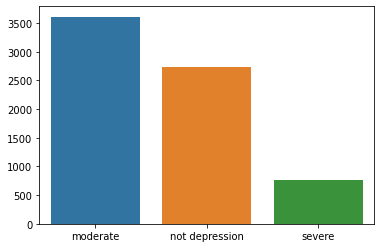

In [139]:
sns.barplot(x=df['Label'].value_counts().index, y=df['Label'].value_counts().values)

Most rows are labeled as moderate depression(3611), on second place we have not depresion (2746) and the fewest: severe depression (762).
For this classification case we need to have labels 0, 1 and 2, because for some classifiers it is mandatory. To simulate intensivity of depression target will be changed as below:

In [143]:
df["Label"].replace({"not depression": 0, "moderate": 1, "severe": 2}, inplace=True)

In [144]:
X = df['Text_data']
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify = y)

# 2. Data exploration

Let's check what words are mostly used for severe and moderately depressed users. There are some tokenizers and we will choose casual tokenizer which is dedicated for social media. We will also add lematizaion (it will find base of the word, not removing/replacing word suffixes as in stemming) and delete stop words. 

In [198]:
text_data_severe = df[df["Label"]==2]["Text_data"]
text_data_moderate = df[df["Label"]==1]["Text_data"]

In [202]:
text_data_severe

599     Falling in love with depression and OCD. Anoth...
608     I’m so empty : I wake up to the malevolent gla...
609     I can't kill myself because of my parents : I ...
616     Feeling numb. : Okay this is my first post, ap...
639     I can't do this anymore. : I have several ment...
                              ...                        
7110    Aren’t we all just tired? : I’ve been depresse...
7111    NEED HELP COPING : I had my life pretty much f...
7112    Qutting Zoloft Cold Turkey : I was on 75 mg se...
7113    Crying : I’m coming off my antidepressants and...
7114    Seeking for advice on how to overcome and deal...
Name: Text_data, Length: 762, dtype: object

In [203]:
text_data_moderate

0       Waiting for my mind to have a breakdown once t...
1       My new years resolution : I'm gonna get my ass...
2       New year : Somone else Feeling like 2020 will ...
3       My story I guess : Hi, Im from Germany and my ...
4       Sat in the dark and cried myself going into th...
                              ...                        
4981    Lockdown has made so depressed : Help me, I fe...
4982    Am i just being dramatic? Do i really feel thi...
4983    Just another day of dealing with Depression. J...
4984    I just want to vent a bit, nothing special ple...
4985    Shit fucking day : Having the shittest day, do...
Name: Text_data, Length: 3611, dtype: object

I will prepare function for finding top 20 (defould value) most common words from all type users.

In [235]:
stop_words = stopwords.words('english') 
ps = PorterStemmer()
wl = WordNetLemmatizer()

def most_common_words(data, words_number=20):
    '''Returns 20 (defoult value) most common words from data using stop words, casual tokenizer and lematizer'''
    
    casual_tekenizer_lists = [casual_tokenize(post) for post in data]
    casual_tekenizer = list(np.concatenate(casual_tekenizer_lists).flat)
    without_stop_words = [word for word in casual_tekenizer if word.lower() not in stop_words and word.isalpha()]
    after_lem = [wl.lemmatize(word) for word in without_stop_words]
    return Counter(after_lem).most_common(words_number)

Let's check what are mostly used words in both group with severe and moderate depression.

In [238]:
top_severe_words = most_common_words(text_data_severe)
print(top_severe_words)

[('like', 1213), ('feel', 1200), ('want', 1073), ('get', 832), ('know', 820), ('time', 736), ('life', 704), ('year', 699), ('depression', 682), ('day', 622), ('even', 565), ('really', 555), ('thing', 526), ('friend', 518), ('go', 512), ('people', 503), ('would', 474), ('help', 443), ('one', 440), ('die', 433)]


In [239]:
top_moderate_words = most_common_words(text_data_moderate)
print(top_moderate_words)

[('like', 4745), ('feel', 4719), ('know', 3190), ('want', 3122), ('life', 2802), ('get', 2794), ('time', 2695), ('friend', 2227), ('even', 2200), ('year', 2160), ('thing', 2029), ('really', 2017), ('people', 2009), ('day', 1845), ('one', 1837), ('go', 1682), ('would', 1608), ('make', 1555), ('depression', 1516), ('think', 1492)]


We can check visually in both groups how frequency of each word relates to the others.

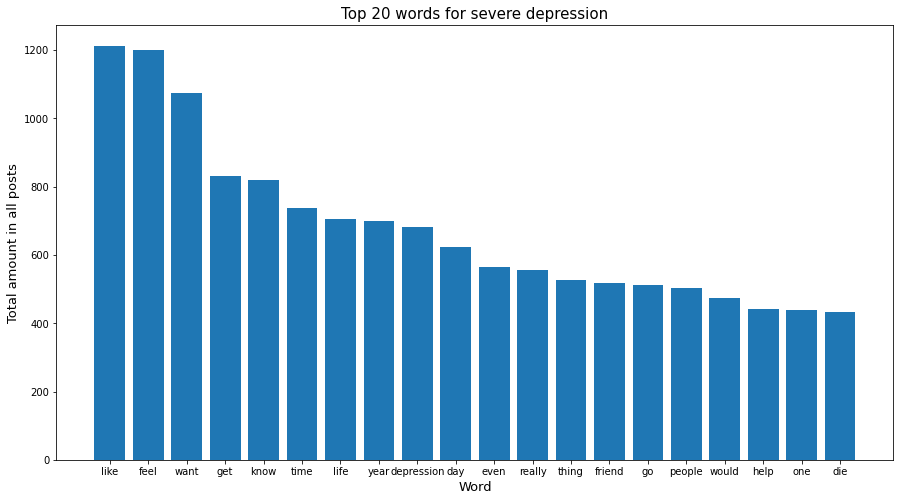

In [247]:
x_list_s = [x[0] for x in top_severe_words]
y_list_s = [x[1] for x in top_severe_words]

plt.figure(figsize=(15, 8))
plt.title("Top 20 words for severe depression", fontsize=15)
plt.xlabel("Word", fontsize=13)
plt.ylabel("Total amount in all posts", fontsize=13)
plt.bar(x=x_list_s, height=y_list_s)
plt.show()

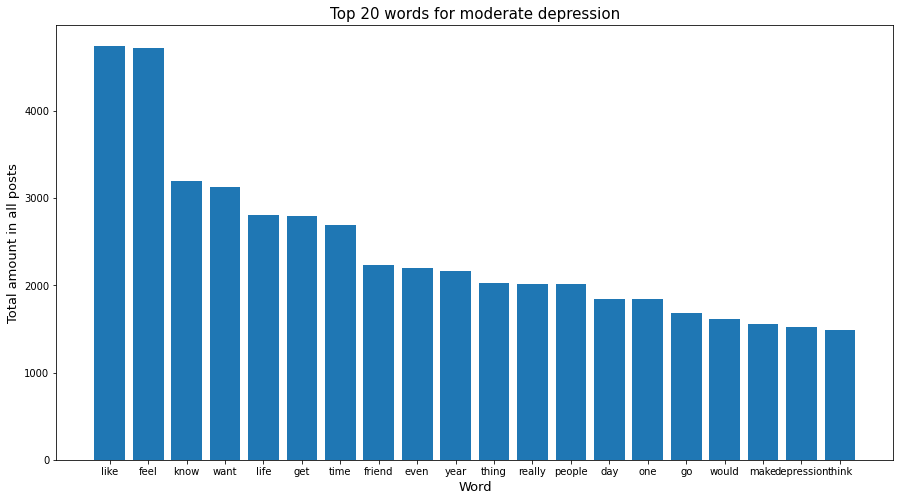

In [248]:
x_list_m = [x[0] for x in top_moderate_words]
y_list_m = [x[1] for x in top_moderate_words]

plt.figure(figsize=(15, 8))
plt.title("Top 20 words for moderate depression", fontsize=15)
plt.xlabel("Word", fontsize=13)
plt.ylabel("Total amount in all posts", fontsize=13)
plt.bar(x=x_list_m, height=y_list_m)
plt.show() 

We can see that two most popular words for both group are the same: like and feel, so it could represent writing in reddit about person emotions and liking/disliking. We can also see that these two words stand out quantitatively from the rest.
Let's check now what words are used in both group and what in each.

In [249]:
words_in_both_group = [x for x in x_list_s if x in x_list_m]
print(f"List of top 20 words which are present in both group moderate and severe depression:\n{words_in_both_group}")

List of top 20 words which are present in both group moderate and severe depression:
['like', 'feel', 'want', 'get', 'know', 'time', 'life', 'year', 'depression', 'day', 'even', 'really', 'thing', 'friend', 'go', 'people', 'would', 'one']


In [251]:
words_only_in_severe = [x for x in x_list_s if x not in x_list_m]
print(f"List of top 20 words which are present only in severe group:\n{words_only_in_severe}")

List of top 20 words which are present only in severe group:
['help', 'die']


In [252]:
words_only_in_severe = [x for x in x_list_m if x not in x_list_s]
print(f"List of top 20 words which are present only in moderate group:\n{words_only_in_severe}")

List of top 20 words which are present only in moderate group:
['make', 'think']


This is very interesting: only people with severe depression use word help and die. Let's check how it will looks like for top 50 words.

In [253]:
top50_severe_words = most_common_words(text_data_severe, words_number=50)
top50_moderate_words = most_common_words(text_data_moderate, words_number=50)

x_list_s50 = [x[0] for x in top50_severe_words]
x_list_m50 = [x[0] for x in top50_moderate_words]

words_only_in_severe50 = [x for x in x_list_s50 if x not in x_list_m50]
print(f"List of top 50 words which are present only in severe group:\n{words_only_in_severe50}")

List of top 50 words which are present only in severe group:
['die', 'anxiety', 'month', 'since', 'bad', 'started', 'week', 'take', 'need']


Now it is more interesint. It could looks like people with severe depression are writing on reddit about death, anxiety and maybe when it could started (words: since and started).

In [74]:
vectorizer = CountVectorizer(max_features=10000)
X = vectorizer.fit_transform(df['Text_data'])
y = df['Label']

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [79]:
models = [LogisticRegression(), DecisionTreeClassifier(), MultinomialNB(), SVC(), KNeighborsClassifier()]
for model in models:
    model.fit(X_train, y_train)
    accuracy = accuracy_score(y_test, model.predict(X_test))
    print(f"{model} model perform with accuracy score: {accuracy}")

/opt/homebrew/Cellar/jupyterlab/3.3.2/libexec/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression() model perform with accuracy score: 0.8909295352323838
DecisionTreeClassifier() model perform with accuracy score: 0.8845577211394303
MultinomialNB() model perform with accuracy score: 0.8354572713643178
SVC() model perform with accuracy score: 0.7747376311844077
KNeighborsClassifier() model perform with accuracy score: 0.8586956521739131
